In [3]:
import torch
from models import Generator
gaf_generator = Generator()
gaf_generator.load_state_dict(torch.load('trained_gen_weights.pt'))
gaf_generator.eval()

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (cnn): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.3, inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

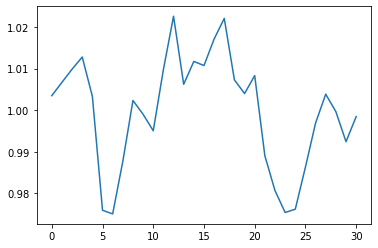

In [4]:
from transforms import reverse_gaf
import numpy as np
import matplotlib.pyplot as plt

def generate_volatility():
    x = torch.randn(1, 100)
    gaf = gaf_generator(x).squeeze()
    log_prices = reverse_gaf(gaf).detach().numpy()
    prices = np.exp(log_prices)
    returns = prices[1:]/prices[:-1]-1
    normalized_returns = (returns-returns.mean())/returns.std()
    return normalized_returns


sp500_std = 0.01
sp500_mean = 0.0

sp500_returns = generate_volatility()*sp500_std + sp500_mean

sp500_prices = np.cumprod(1+sp500_returns)
plt.plot(sp500_prices)

In [5]:
from dataset import ForexData
forex_data = ForexData('data/eurusd_minute.csv', 'BidClose', 32, transforms=[])

def extract_volatility():
    idx = np.random.randint(0, len(forex_data))
    log_prices = forex_data[idx].numpy()
    prices = np.exp(log_prices)
    returns = prices[1:]/prices[:-1]-1
    normalized_returns = (returns-returns.mean())/returns.std()
    return normalized_returns

Loading data from data/eurusd_minute.csv
Loaded 161382 data points


In [6]:
def generate(std,mean,volatility):
    returns = volatility*std + mean
    prices = np.cumprod(1+returns)
    return prices

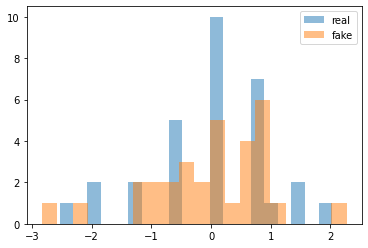

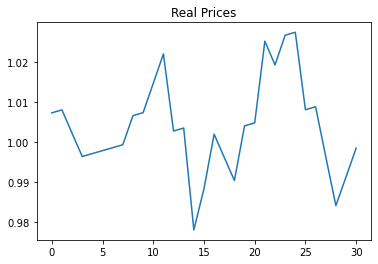

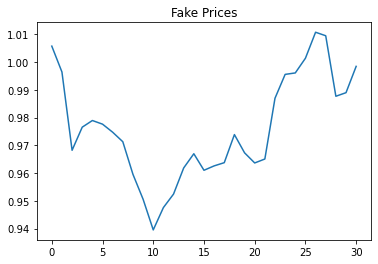

In [31]:
real_v=extract_volatility()
fake_v=generate_volatility()

plt.hist(real_v, alpha=0.5, label='real', bins=20)
plt.hist(fake_v, alpha=0.5, label='fake', bins=20)
plt.legend()
plt.show()
real_prices = generate(sp500_std,sp500_mean,real_v)
fake_prices = generate(sp500_std,sp500_mean,fake_v)
plt.plot(real_prices)
plt.title('Real Prices')
plt.show()
plt.plot(fake_prices)
plt.title('Fake Prices')
plt.show()

/tmp/ipykernel_13800/3143950052.py:9: RuntimeWarning: invalid value encountered in true_divide
  normalized_returns = (returns-returns.mean())/returns.std()


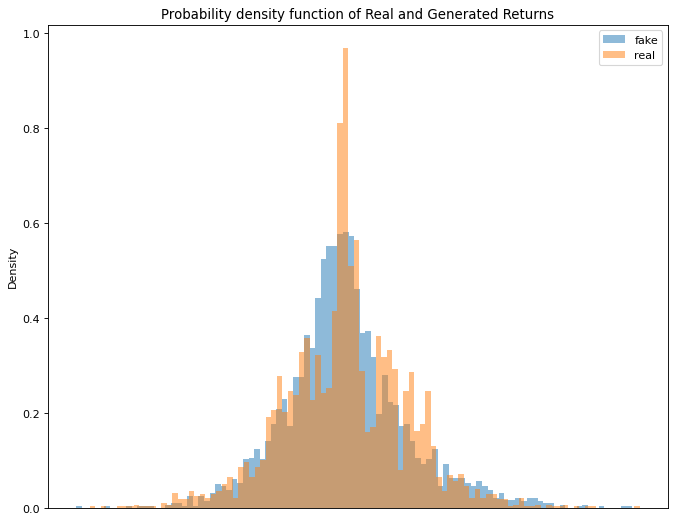

In [47]:
num = 100
fakes = np.array([generate_volatility() for _ in range(num)]).reshape(-1)
reals = np.array([extract_volatility() for _ in range(num)]).reshape(-1)

from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)

plt.hist(fakes, alpha=0.5, label='fake', bins=100, density=True)
plt.hist(reals, alpha=0.5, label='real', bins=100, density=True)
plt.xticks([])
plt.legend()
plt.title('Probability density function of Real and Generated Returns')
plt.ylabel('Density')           
plt.show()